In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import pandas as pd
import numpy as np
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.ticker as ticker

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels

In [11]:
from rkhs import compute_adaptive_threshold, setup_full_cvx_dual
from Synthetic_data_generation import generate_cqr_data

In [22]:
def run_interpolation_trial(alpha, radii, n_calib, gamma, eps = 0.00001):

    x_train_final, y_train_final, x_calib, y_calib, x_test, y_test = generate_cqr_data(n_train = 2*n_calib)

    reg = LinearRegression().fit(x_train_final, y_train_final)
    scores_calib = np.abs(reg.predict(x_calib) - y_calib)
        
    prob = setup_full_cvx_dual(
        x_calib, scores_calib, "rbf", gamma, alpha
    )
    K = pairwise_kernels(
            X=x_calib,
            metric="rbf",
            gamma=gamma
        )
    frac_interpolated = []
    for radius in radii:
        prob.param_dict['radius'].value = np.asarray([[radius]])
        prob.solve(
                solver='MOSEK', 
                verbose=False, 
                mosek_params={mosek.iparam.intpnt_solve_form: mosek.solveform.dual}
        )
        resids = (scores_calib -
                    K @ prob.var_dict['weights'].value -
                    prob.constraints[2].dual_value)
        frac_interpolated.append(sum(np.abs(resids) < eps)/len(scores_calib))
    return frac_interpolated

num_radii=20
radii = np.linspace(1,2000,num_radii)
n_calibs = [250,500,750,1000,1500,2000]
alpha = 0.9
gamma = 2
n_trials=20

df = pd.DataFrame()
for i in tqdm(range(n_trials)):
    for n in n_calibs:
        frac_interpolated = run_interpolation_trial(alpha,radii,n,gamma)
        a_df = pd.DataFrame({'radius' : radii, 'frac_interpolated': frac_interpolated})
        a_df['n_calib'] = n
        df = pd.concat([df, a_df], axis=0)



100%|████████████████████████████████████████| 20/20 [1:09:24<00:00, 208.24s/it]


         radius  frac_interpolated  n_calib    lambda
0      1.000000             0.0000      250  1.000000
1    106.210526             0.0320      250  0.009415
2    211.421053             0.0440      250  0.004730
3    316.631579             0.0400      250  0.003158
4    421.842105             0.0240      250  0.002371
..          ...                ...      ...       ...
15  1579.157895             0.0055     2000  0.000633
16  1684.368421             0.0055     2000  0.000594
17  1789.578947             0.0055     2000  0.000559
18  1894.789474             0.0070     2000  0.000528
19  2000.000000             0.0065     2000  0.000500

[2400 rows x 4 columns]


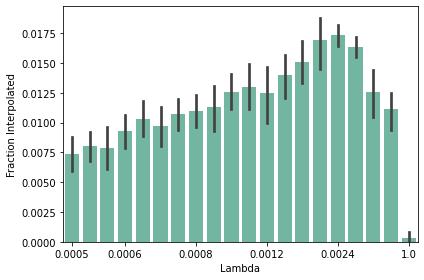

In [86]:
import seaborn as sns
import pandas as pd

df['lambda'] = 1/df['radius']
melted_df = pd.melt(df[df['n_calib'] == 500], id_vars=['lambda'], value_vars=['frac_interpolated'])
melted_df = melted_df.rename(columns={"lambda": "Lambda", "value": "Fraction Interpolated"})

fig = sns.barplot(
    melted_df, 
    x='Lambda', 
    y='Fraction Interpolated',
    hue='variable',
    palette=sns.color_palette("Set2")
)
fig.legend_.remove()

tick_locations = list(range(-1,num_radii,4))
tick_locations[0] = 0
tick_labels = [round(1/radii[num_radii - i - 1], 4) for i in tick_locations]


fig.xaxis.set_major_locator(ticker.FixedLocator(tick_locations))
fig.xaxis.set_major_formatter(ticker.FixedFormatter(tick_labels))

plt.tight_layout()
#fig.get_figure().savefig('interpolation.png')
